In [36]:
# Suppress warning messages
import warnings
warnings.filterwarnings('ignore')
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import json
import itertools
import glob
import sys
import requests
import random
import pickle
import joblib
import imageio
import PIL
from tabulate import tabulate
from pathlib import Path
from PIL import ImageFont, Image

# Machine learning libraries
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, cross_val_predict, GridSearchCV
from skimage.transform import resize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import preprocessing
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Activation, Conv2D, Dense, Flatten, MaxPooling2D, AveragePooling2D, Reshape
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping

# Suppress Tensorflow warnings and errors
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Import model
from ultralytics import YOLO

In [37]:
!pip install imageio


[notice] A new release of pip available: 22.2.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [38]:
!pip install tabulate

UnboundLocalError: local variable 'child' referenced before assignment

In [ ]:
!pip install scikit-image


[notice] A new release of pip available: 22.2.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [ ]:
# Any edits to libraries are reloaded automatically
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# 1) data exploration


In [ ]:
styles = ['Achaemenid architecture','American craftsman style','American Foursquare architecture','Ancient Egyptian architecture','Art Deco architecture',
    'Art Nouveau architecture','Baroque architecture','Bauhaus architecture','Beaux-Arts architecture','Byzantine architecture',
    'Chicago school architecture','Colonial architecture','Deconstructivism','Edwardian architecture','Georgian architecture',
    'Gothic architecture','Greek Revival architecture','International style','Novelty architecture','Palladian architecture',
    'Postmodern architecture','Queen Anne architecture','Romanesque architecture','Russian Revival architecture','Tudor Revival architecture']

## Load & Preprocess 

In [ ]:
# Separate image dataset into features and labels (target = style)
X = []
y = []

# Set size for images to be resized to
size = (256, 256)

# Put images in X and their labels in y
for style in styles[:]:
    img_file = glob.glob(f'/Users/lorisduray/code/lorisduray/architectural_styles/archi_project/raw_data/yolo_dataset/architectural-styles-dataset/**/{style}/*.jpg', recursive = True)
    print(f"Found {len(img_file)} images for style '{style}'")


    # Resize and grayscale each image
    for i, f in enumerate(img_file):
        img = cv2.imread(f)
        img = cv2.resize(img, size, interpolation = cv2.INTER_AREA)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = np.array(img)
        img = img.astype('float32')
        img /= 255
        X.append(img)
        y.append(style)

Found 373 images for style 'Achaemenid architecture'
Found 322 images for style 'American craftsman style'
Found 337 images for style 'American Foursquare architecture'
Found 361 images for style 'Ancient Egyptian architecture'
Found 427 images for style 'Art Deco architecture'
Found 491 images for style 'Art Nouveau architecture'
Found 376 images for style 'Baroque architecture'
Found 295 images for style 'Bauhaus architecture'
Found 355 images for style 'Beaux-Arts architecture'
Found 285 images for style 'Byzantine architecture'
Found 237 images for style 'Chicago school architecture'
Found 408 images for style 'Colonial architecture'
Found 278 images for style 'Deconstructivism'
Found 266 images for style 'Edwardian architecture'
Found 366 images for style 'Georgian architecture'
Found 330 images for style 'Gothic architecture'
Found 449 images for style 'Greek Revival architecture'
Found 367 images for style 'International style'
Found 327 images for style 'Novelty architecture'
F

In [ ]:
print(f'X size:{len(X)}')
print(f'y size:{len(y)}')

X size:53092
y size:53092


## Display a sample

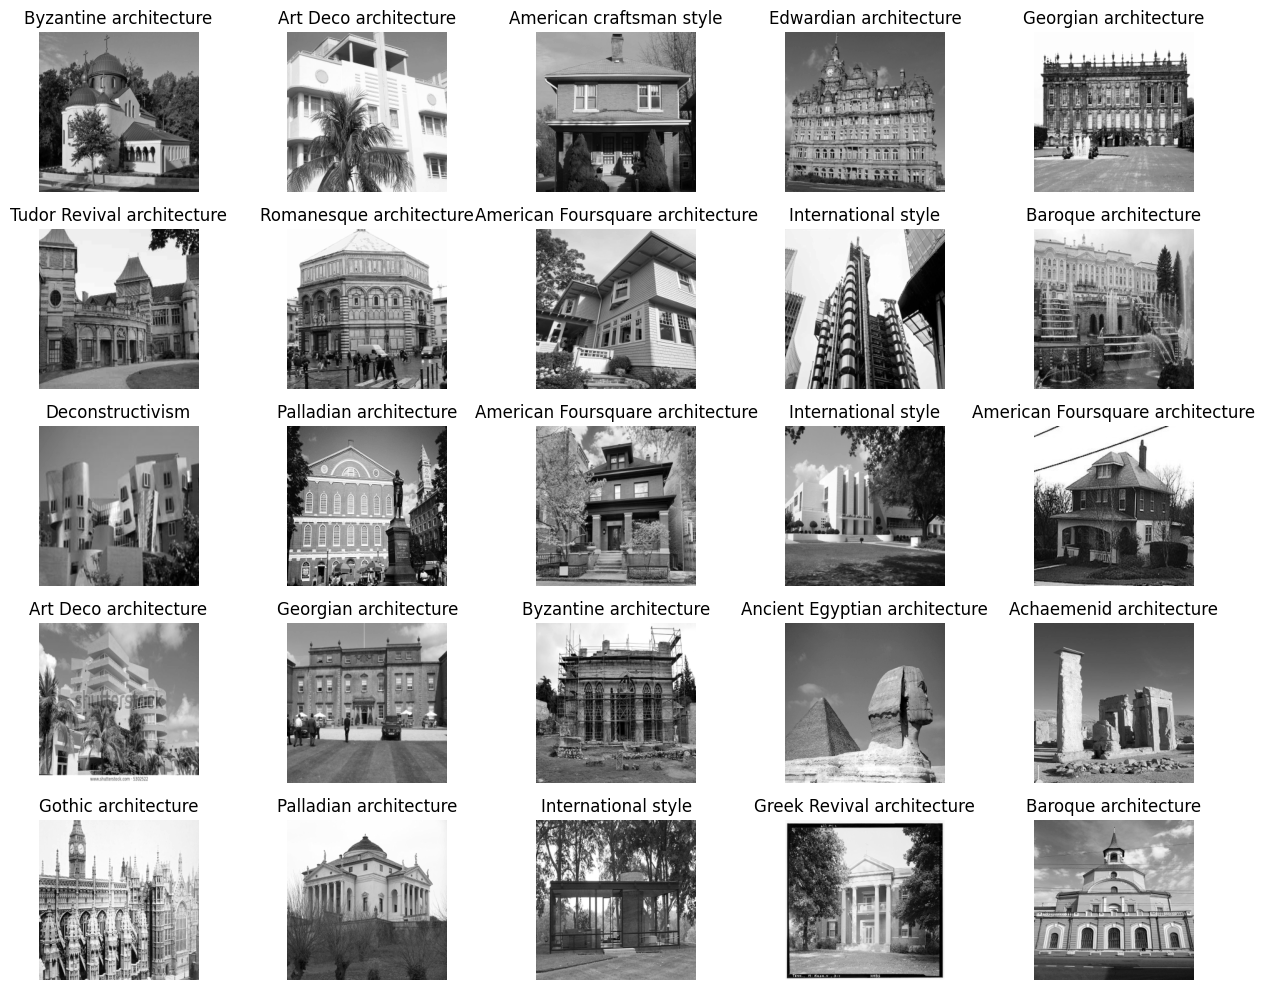

In [ ]:
# Function to display a grid of images
def display_images(images, titles, rows=5, cols=5):
    fig, axes = plt.subplots(rows, cols, figsize=(13, 10))
    axes = axes.flatten()
    for img, ax, title in zip(images, axes, titles):
        ax.imshow(img, cmap='gray')
        ax.set_title(title)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Display a sample of images
sample_size = 25  # Number of images to display
sample_indices = np.random.choice(len(X), sample_size, replace=False)
sample_images = [X[i] for i in sample_indices]
sample_titles = [y[i] for i in sample_indices]

display_images(sample_images, sample_titles, rows=5, cols=5)

## Data augmentation

In [ ]:
def augment_image(img):
    augmented_images = []

    # Horizontal flip
    flip_horizontal = cv2.flip(img, 1)
    augmented_images.append(flip_horizontal)

    # Vertical flip
    flip_vertical = cv2.flip(img, 0)
    augmented_images.append(flip_vertical)

    # Rotation
    rows, cols = img.shape
    M = cv2.getRotationMatrix2D((cols / 2, rows / 2), 15, 1)
    rotated = cv2.warpAffine(img, M, (cols, rows))
    augmented_images.append(rotated)

    # Scaling
    scaled = cv2.resize(img, None, fx=1.2, fy=1.2, interpolation=cv2.INTER_LINEAR)
    scaled = cv2.resize(scaled, (cols, rows), interpolation=cv2.INTER_AREA)
    augmented_images.append(scaled)

    # Brightness adjustment
    bright = cv2.convertScaleAbs(img, alpha=1.2, beta=30)
    augmented_images.append(bright)

    return augmented_images

In [ ]:
for style in styles:
    img_file = glob.glob(f'/Users/lorisduray/code/lorisduray/architectural_styles/archi_project/raw_data/yolo_dataset/architectural-styles-dataset/**/{style}/*.jpg', recursive = True)
    print(f"Found {len(img_file)} images for style {style}")

    # Resize and grayscale each image
    for i, f in enumerate(img_file):
        img = cv2.imread(f)
        if img is None:
            print(f"Failed to read image {f}")
            continue

        img = cv2.resize(img, size, interpolation=cv2.INTER_AREA)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Convert image to float32 and normalize
        img = img.astype('float32')
        img /= 255

        # Apply augmentation and append augmented images to X
        augmented_images = augment_image(img)
        for aug_img in augmented_images:
            X.append(aug_img)
            y.append(style)

Found 373 images for style Achaemenid architecture
Found 322 images for style American craftsman style
Found 337 images for style American Foursquare architecture
Found 361 images for style Ancient Egyptian architecture
Found 427 images for style Art Deco architecture
Found 491 images for style Art Nouveau architecture
Found 376 images for style Baroque architecture
Found 295 images for style Bauhaus architecture
Found 355 images for style Beaux-Arts architecture
Found 285 images for style Byzantine architecture
Found 237 images for style Chicago school architecture
Found 408 images for style Colonial architecture
Found 278 images for style Deconstructivism
Found 266 images for style Edwardian architecture
Found 366 images for style Georgian architecture
Found 330 images for style Gothic architecture
Found 449 images for style Greek Revival architecture
Found 367 images for style International style
Found 327 images for style Novelty architecture
Found 312 images for style Palladian ar

In [ ]:
print(f'X size:{len(X)}')
print(f'y size:{len(y)}')

X size:53092
y size:53092


## split the data

In [ ]:
# Cast labels to integers
y = [styles.index(label) for label in y]

# Convert lists to numpy arrays
X = np.array(X)
y = np.array(y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)


In [ ]:
print(f'Training set size: {len(X_train)}')
print(f'Validation set size: {len(X_valid)}')
print(f'Test set size: {len(X_test)}')


Training set size: 33978
Validation set size: 8495
Test set size: 10619


# 2) Load model

In [ ]:
model = YOLO("yolov8n.pt")

100%|██████████| 6.25M/6.25M [00:00<00:00, 10.5MB/s]


In [ ]:
model

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_s

In [ ]:
from roboflow import Roboflow
rf = Roboflow(api_key="D6K5bSugKqBXIOMSkP08")
project = rf.workspace("architecture-m622x").project("architectural-styles-73lmb")
version = project.version(1)
dataset = version.download("yolov8")


loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.196 is required but found version=8.2.74, to fix: `pip install ultralytics==8.0.196`



Extracting Dataset Version Zip to -architectural-styles--1 in yolov8:: 100%|██████████| 1842/1842 [00:00<00:00, 8933.37it/s]


In [ ]:
!yolo task=detect mode=train model=yolov8m.pt data=/Users/lorisduray/code/lorisduray/architectural_styles/archi_project/notebook/-architectural-styles--1/data.yaml epochs=2 imgsz=915

Ultralytics YOLOv8.2.74 🚀 Python-3.10.6 torch-2.4.0 CPU (Apple M2)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/Users/lorisduray/code/lorisduray/architectural_styles/archi_project/notebook/-architectural-styles--1/data.yaml, epochs=5, time=None, patience=100, batch=16, imgsz=915, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train4, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_co

In [ ]:
!yolo task=detect mode=train model=yolov8m.pt data=/Users/lorisduray/code/lorisduray/architectural_styles/archi_project/notebook/-architectural-styles--1/data.yaml epochs=2 imgsz=915

Ultralytics YOLOv8.2.74 🚀 Python-3.10.6 torch-2.4.0 CPU (Apple M2)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/Users/lorisduray/code/lorisduray/architectural_styles/archi_project/notebook/-architectural-styles--1/data.yaml, epochs=2, time=None, patience=100, batch=16, imgsz=915, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train6, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_co

In [ ]:
results_csv = 'runs/detect/train6/results.csv'
df = pd.read_csv(results_csv)
print(df.head())

                  epoch        train/box_loss        train/cls_loss  \
0                     1               0.62519                2.0901   
1                     2               0.34017                1.0572   

         train/dfl_loss  metrics/precision(B)     metrics/recall(B)  \
0                1.3226               0.28743               0.39933   
1                1.0857               0.76982               0.75764   

       metrics/mAP50(B)   metrics/mAP50-95(B)          val/box_loss  \
0               0.28210               0.05852                3.1741   
1               0.77036               0.48960                1.3756   

           val/cls_loss          val/dfl_loss                lr/pg0  \
0                4.9826               2.01490              0.000409   
1                2.2052               0.58603              0.000417   

                 lr/pg1                lr/pg2  
0              0.000409              0.000409  
1              0.000417              0.000417  


In [ ]:

from roboflow import Roboflow
rf = Roboflow(api_key="D6K5bSugKqBXIOMSkP08")
project = rf.workspace("umut-3r7tf").project("arch2")
version = project.version(1)
dataset = version.download("multiclass")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to arch2-1 in multiclass:: 100%|██████████| 21221/21221 [00:02<00:00, 8446.86it/s]


In [ ]:


from roboflow import Roboflow
rf = Roboflow(api_key="D6K5bSugKqBXIOMSkP08")
project = rf.workspace("yaskova").project("archstyles-multi-class")
version = project.version(1)
dataset = version.download("multiclass")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to ArchStyles-multi-class-1 in multiclass:: 100%|██████████| 22113/22113 [00:03<00:00, 5855.69it/s]


In [ ]:


from roboflow import Roboflow
rf = Roboflow(api_key="D6K5bSugKqBXIOMSkP08")
project = rf.workspace("test-1-architective-mvp").project("architective-architectural-style-image-classification-model")
version = project.version(6)
dataset = version.download("folder")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to ArchiTective:-Architectural-Style-Image-Classification-Model-6 in folder:: 100%|██████████| 4297/4297 [00:00<00:00, 5939.91it/s]
